# Import Libraries

In [1]:
from cm_api import *
from cm_config import config
import datetime
from helper_funct import *
from helper_funct1 import *
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [45]:
rt = config['refresh_token']
api_token = get_api_token(rt)

# Collect Data From Tiktok Weekly Chart

In [35]:
data = get_tiktok_chart_data(api_token, 'tracks', '2021-03-09', 'weekly')

In [43]:
data[21].keys()

dict_keys(['id', 'tiktok_track_id', 'name', 'isrc', 'image_url', 'cm_track', 'tiktok_artist_names', 'tiktok_track_ids', 'album_ids', 'album_names', 'album_upc', 'album_label', 'release_dates', 'rank', 'weekly_posts', 'added_at', 'tiktok', 'velocity', 'pre_rank', 'peak_rank', 'peak_date', 'time_on_chart', 'rankStats'])

# Parse Tiktok Data
parse raw data into pandas dataframe with the following columns:

'rank', 'added_at', 'title', 'artist', 'isrc', 'velocity', 'cm_id', 'time_on_chart', 'release_dates']

In [39]:
tiktok_df = parse_tiktok_data(data)

In [41]:
tiktok_df.loc[tiktok_df['artist'] == 'mark']

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates
21,22,2021-03-09T00:00:00.000Z,Welcome to New York by Taylor Swift,mark,USCJY1431299,1.714286,15191524.0,16,"[2014-10-27T00:00:00.000Z, 2014-10-27T00:00:00..."


# Get Artist IDs (Chartmetric)

In [19]:
def create_artist_id_feat(dataframe):
    from cm_api import get_track_metadata
    bucket = []
    for row in dataframe.iterrows():
        track_id = row[1]['cm_id']
        artist_id = get_track_metadata(api_token, track_id)['artists'][0]['id']
        bucket.append(artist_id)

    dataframe['cm_artist_id'] = bucket
    return dataframe

In [22]:
df = create_artist_id_feat(tiktok_df)

# Data Cleaning

## remove timestamp from add date

In [26]:
df['added_at'] = pd.to_datetime(df['added_at']).dt.date

## Engineer `Before_Tiktok_Date`
7 days before record's first occurance on Tiktok chart. `added_at` - (`time_on_chart` + 7)

In [31]:
def create_before_tiktok_date_feat(dataframe):
    #takes in dataframe with `added_at` and `time_on_chart`
    #returns dataframe with new date feature
    bucket = []
    for row in dataframe.iterrows():
        add_date = row[1]['added_at'] #get add_date of chart
        days = int(row[1]['time_on_chart']) + 7 #adding 7 to total time on chart
        bucket.append(add_date - datetime.timedelta(days=days))

    dataframe['Before_Tiktok_Date'] = bucket
    return dataframe
    

In [32]:
df1 = create_before_tiktok_date_feat(df)

In [40]:
df1.sort_values('Before_Tiktok_Date', ascending=True)

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,cm_artist_id,Before_Tiktok_Date
66,67,2021-03-09,Classical Music,Classical Music,TCAAU1178628,1.428571,20877140.0,301,[2011-02-03T00:00:00.000Z],141006,2020-05-05
94,95,2021-03-09,ily (i love you baby),Surf Mesa,QZJRC1945204,NaN,27755710.0,267,"[2019-11-26T00:00:00.000Z, 2019-11-26T00:00:00...",1793858,2020-06-08
55,56,2021-03-09,Monkeys Spinning Monkeys,Kevin MacLeod,USUAN1400011,-0.285714,17158836.0,266,"[2014-12-30T00:00:00.000Z, 2019-10-10T00:00:00...",333690,2020-06-09
3,4,2021-03-09,Aesthetic,Xilo,QZFZ22071847,-0.285714,28796568.0,262,[2020-02-14T00:00:00.000Z],3377623,2020-06-13
29,30,2021-03-09,Steven Universe,L.Dre,QZFZ32084911,7.142857,28637630.0,260,[2020-02-21T00:00:00.000Z],751357,2020-06-15
...,...,...,...,...,...,...,...,...,...,...,...
12,13,2021-03-09,Apaga a Luz Apaga Tudo 150Bpm,MC Topre,US7VG2175883,NaN,32999109.0,6,[2021-02-22T00:00:00.000Z],720112,2021-02-24
96,97,2021-03-09,Быстро,Colorit,RUB422100407,NaN,32954965.0,6,[2021-02-22T00:00:00.000Z],4143223,2021-02-24
48,49,2021-03-09,Pull Me Closer,Dimitri Vegas,BEG852100008,NaN,33198004.0,6,[2021-03-05T00:00:00.000Z],1595488,2021-02-24
42,43,2021-03-09,Reloj,Rauw Alejandro & Anuel AA,USSD12000471,NaN,31750071.0,5,"[2020-10-22T00:00:00.000Z, 2020-11-13T00:00:00...",224838,2021-02-25


# Engineer `total_spotify_followers`
total Spotify followers on `Before_Tiktok_Date`

In [49]:
def create_spotify_followers_before_feat(dataframe):
    from cm_api import get_fan_metrics
    bucket = []
    for row in dataframe.iterrows():
        before_date = row[1]['Before_Tiktok_Date']
        after_date = row[1]['Before_Tiktok_Date'] + datetime.timedelta(days=5)
        artist_id = row[1]['cm_artist_id']
        data = get_fan_metrics(api_token, artist_id,'spotify', before_date, after_date, field='followers')['followers']
        if len(data) > 0:
            tup = (data[0]['value'], data[-1]['value'])
            bucket.append(tup)
        else:
            tup = (None, None)
            bucket.append(tup) 

    dataframe['total_spotify_followers'] = [x[0] for x in bucket]
    return dataframe


In [50]:
df2 = create_spotify_followers_before_feat(df1)

# Feature Engineer - Track Age
categorial value for track age on chart
`a month` == x <=30; `2 months` 60 >= x > 30; `over 2 months` x> 60

In [80]:
int(df2['time_on_chart'][0])

40

In [82]:
df2['track_age'] = df2['time_on_chart'].apply(lambda x: 'a month' if int(x) <= 30 else ('2 months' if 60 >= int(x) > 30 else 'over 2 months'))

## Filter dataset down to records with track age of a month

In [55]:
young_trax = all_trax.loc[all_trax['track_age'] == 'a month'].reset_index().drop(axis=1, labels='index')


### Find IG followers for before date

In [83]:
def create_instagram_followers_before_feat(dataframe):
    from cm_api import get_fan_metrics
    bucket = []
    for row in dataframe.iterrows():
        before_date = str(row[1]['Before_Tiktok_Date'])[:10]
        after_date = str(row[1]['Before_Tiktok_Date'] + datetime.timedelta(days=5))[:10]
        artist_id = row[1]['cm_artist_id']
        data = get_fan_metrics(api_token, artist_id,'instagram', str(before_date), str(after_date), field='followers')['followers']
        if len(data) > 0:
            tup = (data[0]['value'], data[-1]['value'])
            bucket.append(tup)
        else:
            tup = (None, None)
            bucket.append(tup) 

    dataframe['total_ig_followers'] = [x[0] for x in bucket]
    return dataframe

In [84]:
young_trax = create_instagram_followers_before_feat(young_trax)

## Find True Artist Names

In [51]:
def collect_true_artist_names(dataframe):
    from cm_api import get_track_metadata
    bucket = []
    for row in dataframe.iterrows():
        track_id = row[1]['cm_id']
        artist_name = get_track_metadata(api_token, track_id)['artists'][0]['name']
        bucket.append(artist_name)

    dataframe['artist'] = bucket

    return dataframe
    


In [52]:
all_trax = collect_true_artist_names(all_trax)

# Collect Popularity metric for each artist

In [46]:
young_trax = collect_artist_sppop(api_token, new_trax)

# Career Stage
`Established` if spotify popularity >= 88; `Emerging` if spotify popularity >= 80 else indie

In [53]:
young_trax['Career Stage'] = young_trax['artist_pop'].apply(lambda x: 'Established' if x >= 88 else ('Emerging' if x >= 80 else 'Indie'))

In [59]:
mask = young_trax['Career Stage'] == 'Indie'

In [61]:
# young_trax.loc[mask,:]

# Save Dataset



In [56]:
#save full dataset - 85 songs
all_trax.to_csv('/home/bull/Documents/bull-analytics/blog7/data/top_tiktok_artists.csv', index_label='index')

In [54]:
#save dataset of 1 month old records
young_trax.to_csv('/home/bull/Documents/bull-analytics/blog7/data/one_month_trax.csv', index_label='index')

# Read in Datasets

In [58]:
all_trax = pd.read_csv('/home/bull/Documents/bull-analytics/blog7/data/top_tiktok_artists.csv', index_col=0,
                      parse_dates=['added_at','Before_Tiktok_Date'])

In [36]:
new_trax = pd.read_csv('/home/bull/Documents/bull-analytics/blog7/data/one_month_trax.csv', index_col=0,
                      parse_dates=['added_at','Before_Tiktok_Date'])

In [62]:
new_trax.head()

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,cm_artist_id,Before_Tiktok_Date,total_spotify_followers,track_age,total_ig_followers,artist_pop,Career Stage
index,,,,,,,,,,,,,,,,
0,7,2021-03-09,Bad (2012 Remaster),Michael Jackson,USSM18700002,-0.428571,15813757.0,19,"['2012-11-30T00:00:00.000Z', '1995-06-16T00:00...",178,2021-02-11,17375600.0,a month,5796340.0,86.0,Emerging
1,8,2021-03-09,the bob for me,Aqyila,QZFYZ2164782,-0.142857,32651909.0,12,['2020-12-26T00:00:00.000Z'],3760154,2021-02-18,2293.0,a month,12356.0,55.0,Indie
2,9,2021-03-09,Моя голова винтом (My head is spinning like a ...,kostromin,QM4TW2159341,-0.428571,32733452.0,19,['2021-02-02T00:00:00.000Z'],4158039,2021-02-11,2020.0,a month,NaN,67.0,Indie
3,11,2021-03-09,Batman,LPB Poody,USUM72101263,4.000000,32825135.0,11,['2021-02-12T00:00:00.000Z'],1114822,2021-02-19,47095.0,a month,349796.0,65.0,Indie
4,12,2021-03-09,telepatía,Kali Uchis,GBUM72005748,1.285714,32010274.0,21,"['2020-11-18T00:00:00.000Z', '2020-11-18T00:00...",99202,2021-02-09,1340834.0,a month,2211918.0,87.0,Emerging


# Summary Statistics for playlist tracks

In [4]:
summ_stat_playlist_artist_popularity(api_token, playlist_id)

Median popularity for top hit artists is 88

# Pop Rising popularity of artists

In [33]:
data = get_playlist_tracks(api_token, 'spotify', 984513, 'current', 'us')
bucket = []
for track in data:
    tup = (track['cm_artist'][0])
    bucket.append(tup)
df = pd.DataFrame(bucket, columns=['cm_artist_id'])

bucket = []
for row in df.iterrows():
    x = row[1]['cm_artist_id']
    artist_pop = get_artist_metadata(api_token, x)['cm_statistics']['sp_popularity']
    print
    if (artist_pop):
        bucket.append(artist_pop)
    else:
        bucket.append(None)

df['artist_pop'] = bucket

get_summary_statistics(df['artist_pop'].dropna())

Min: 36
Mean: 79
Max: 99
25th percentile: 75
Median: 80
75th percentile: 85
Interquartile range (IQR): 10


Rising artists median popularity is 80

# Analysis

In [198]:
def make_countplot(dataframe,x_series):

    fig = figure(figsize=(20,12))  # define the figure window
    ax1  = fig.add_subplot(111)   # define the axis
    graph = sns.countplot(data=dataframe, x=x_series)
    plt.xticks(rotation=0)
    plt.title('Top Trending Tiktok Tracks - Week of March 9, 2021', size=25)
    plt.ylabel('# of Artists', size=25)
    plt.xlabel('Track Age', size=25)
    plt.ticklabel_format(style='plain', axis='y') #change xaxis from sci to plain style
    plt.tick_params(axis='both', which='major', labelsize=20)

    for bar in graph.patches:
        graph.annotate((format((bar.get_height()/len(df2))*100, '.2f'))+'%', (bar.get_x() + bar.get_width()/2, bar.get_height()+.5), size=20)

    plt.tight_layout()
#     plt.savefig('/home/bull/Documents/bull-analytics/blog7/visuals/track_age.jpeg')
    plt.show()

## Top New Artists by Instagram Followers

In [194]:
# sorted_df.head()

In [200]:
def make_barplot(dataframe, x_series, y_series):

    import matplotlib.pyplot as plt 
    from helper_funct import insert_thousands_commas
    fig = figure(figsize=(35,25))  # define the figure window
    ax1  = fig.add_subplot(111)   # define the axis
    sorted_df = dataframe.sort_values(y_series, ascending=False)[:10]
    graph = sns.barplot(data=sorted_df, x=x_series, y=y_series)
    #label x,y axes
    plt.title('Newest Artists Trending on Tiktok (1-Month on Chart)', size=40)
    plt.xticks(rotation=90)
    plt.ylabel('Total IG Followers - Before Tiktok', size=40)
    plt.xlabel('Artists', size=40)
    plt.ticklabel_format(style='plain', axis='y') #change xaxis from sci to plain style
    plt.tick_params(axis='both', which='major', labelsize=35)
    plt.grid(axis='y', which='major')
    #annotate bars
    oldheight=0
    for bar in graph.patches:
        currentheight = bar.get_height()
        if currentheight > oldheight:

            graph.annotate(insert_thousands_commas(bar.get_height()), (bar.get_x() + bar.get_width()/2, bar.get_height()), 
                           size=40, xytext=(bar.get_x() + bar.get_width()/10, currentheight+3000000), 
                           arrowprops={'arrowstyle':'wedge'})
            oldheight = bar.get_height()
        else:
            graph.annotate(insert_thousands_commas(bar.get_height()), (bar.get_x() + bar.get_width()/2, bar.get_height()), 
                           size=40,xytext=(bar.get_x() + bar.get_width()/10, currentheight+oldheight/2), 
                           arrowprops={'arrowstyle':'wedge'})
            oldheight = bar.get_height()     

    plt.tight_layout()
#     plt.savefig('/home/bull/Documents/bull-analytics/blog7/visuals/top10_artistsIG.jpeg')
    plt.show()

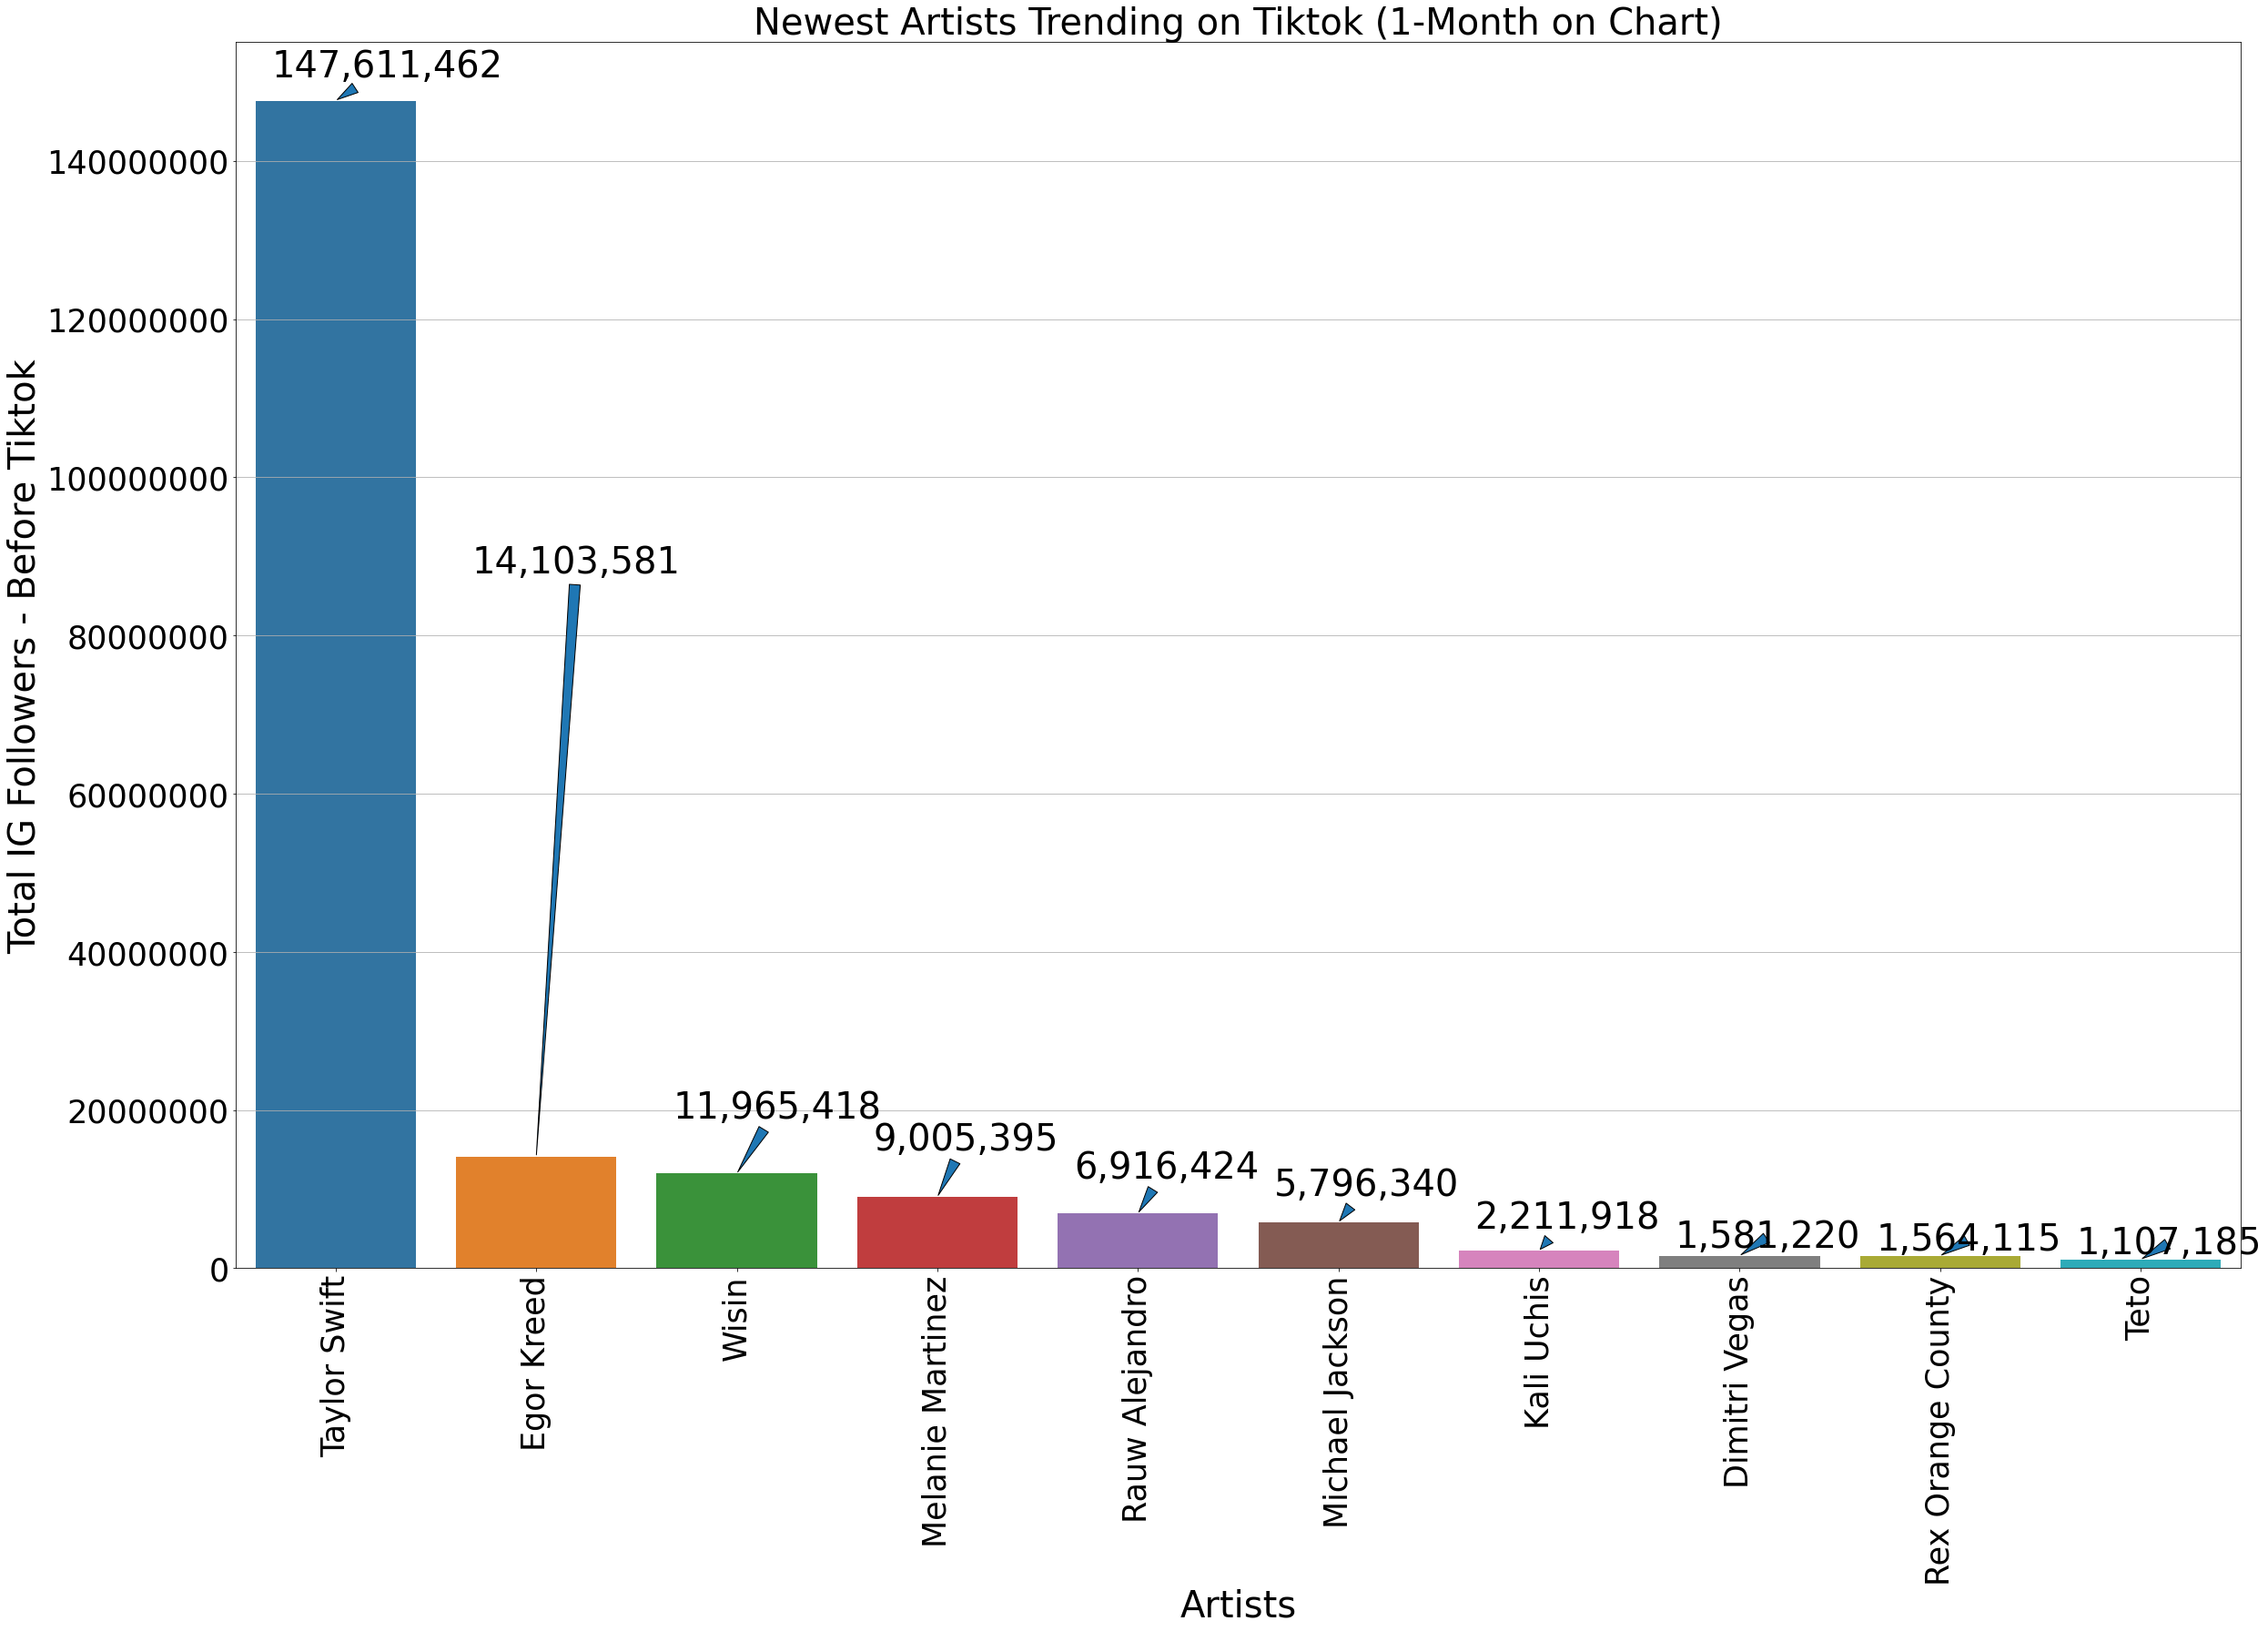

In [202]:
make_barplot(new_trax, 'artist', 'total_ig_followers')

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


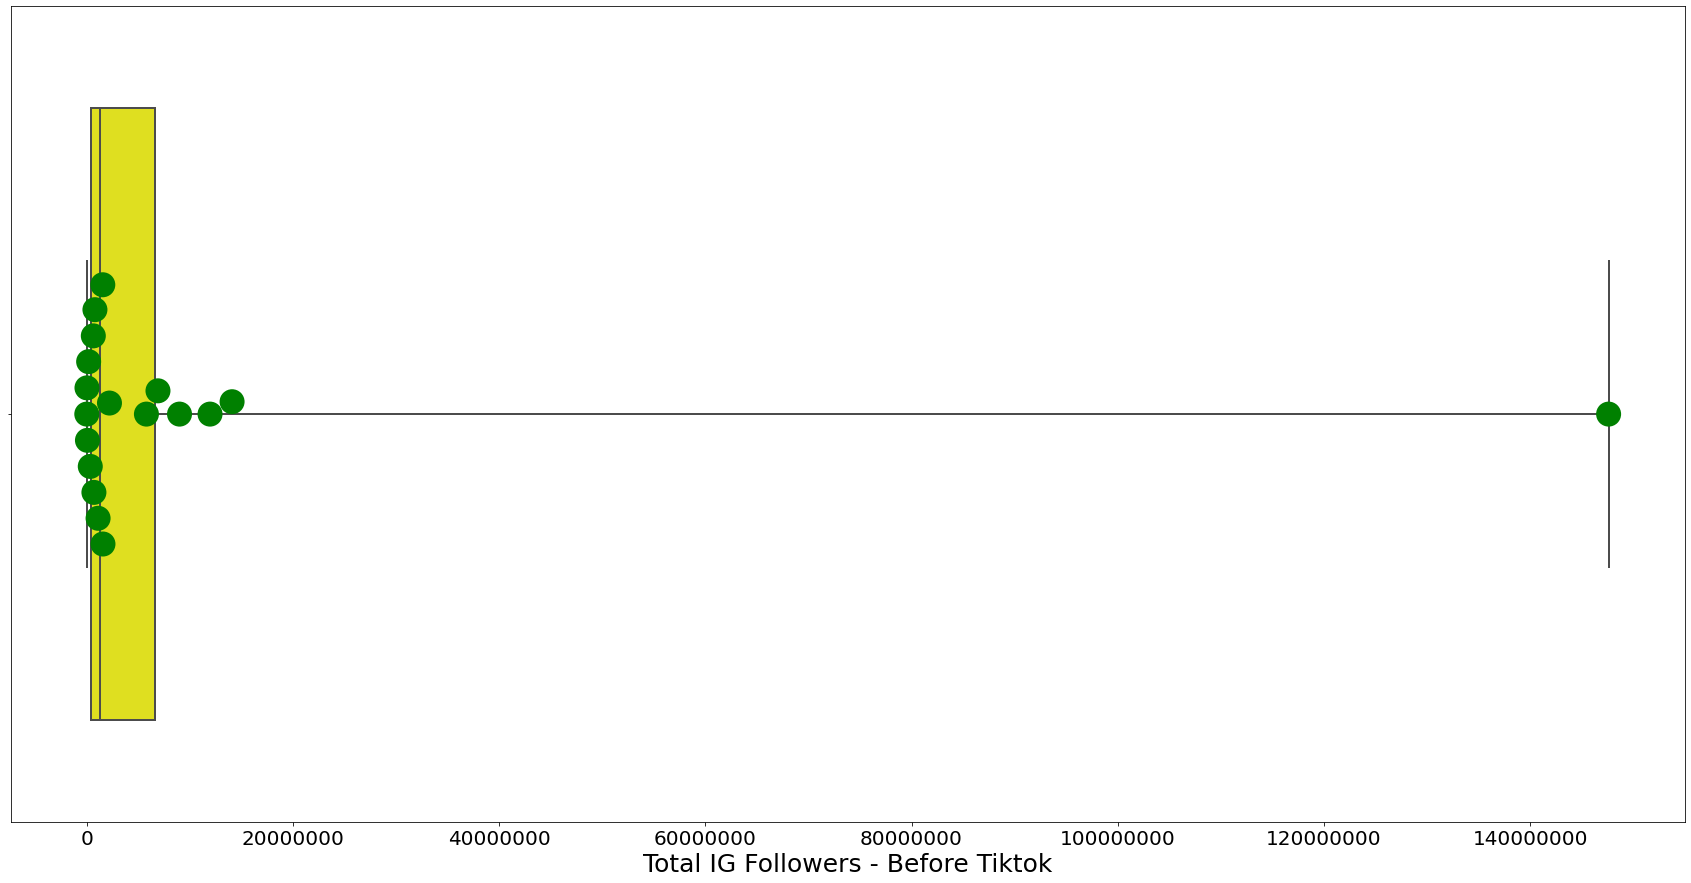

In [33]:
from matplotlib.pyplot import * 

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(new_trax['total_ig_followers'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
#markers with just twitter
sns.swarmplot(data=new_trax,x=new_trax['total_ig_followers'], color='green', size=25)
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Total IG Followers - Before Tiktok', size=25)
plt.xticks(size=20)
plt.show()



In [104]:
get_summary_statistics(yt2['total_ig_followers'].dropna())

Min: 12,356
Mean: 11,370,822
Max: 147,611,462
25th percentile: 423,478
Median: 1,335,650
75th percentile: 6,636,403
Interquartile range (IQR): 6,212,925


In [105]:
#filter dataset to top 50% of total spotify followers

top_artists = yt2.loc[yt2['total_ig_followers'] >= yt2['total_ig_followers'].quantile(.5)]

In [106]:
top_artists.sort_values('total_spotify_followers', ascending=False, inplace=True)

<ipython-input-106-fd6c17aa9078>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_artists.sort_values('total_spotify_followers', ascending=False, inplace=True)


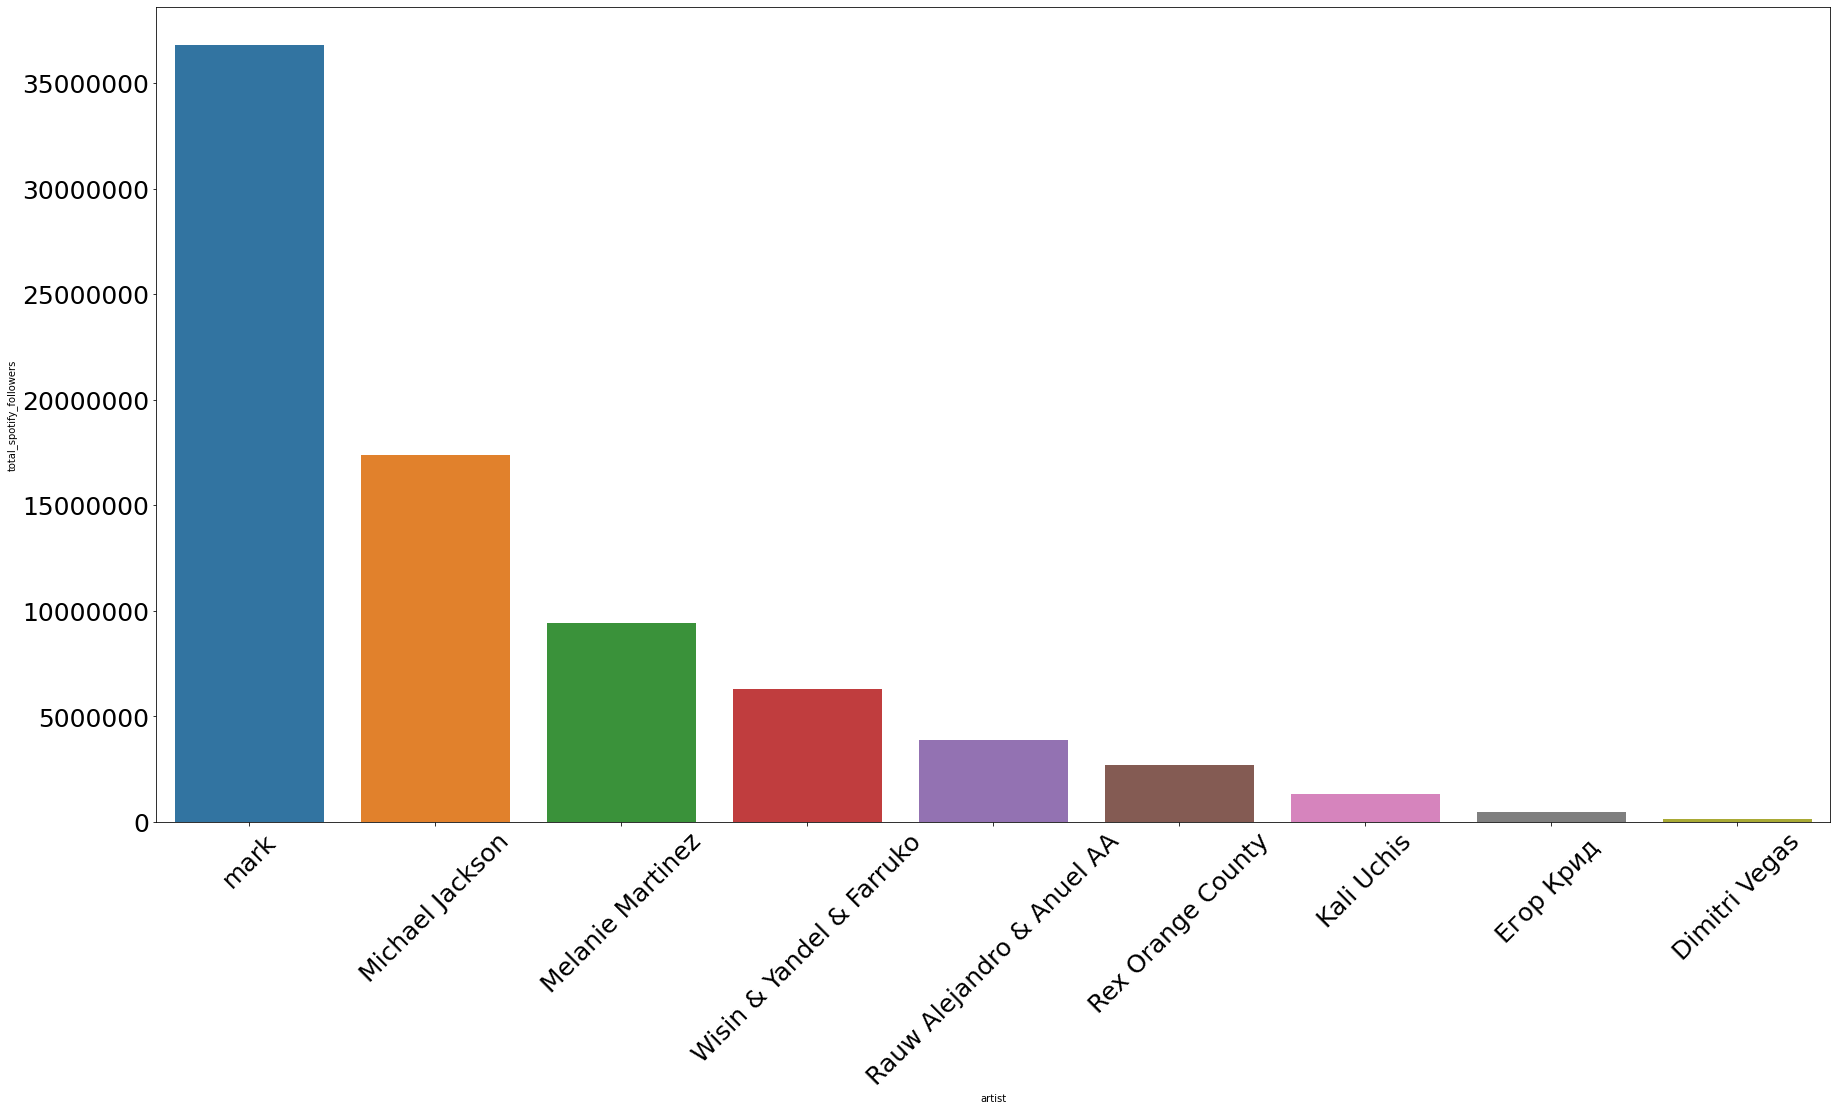

In [108]:
fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.barplot(data=top_artists, x='artist', y='total_spotify_followers')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y') #change xaxis from sci to plain style
plt.tick_params(axis='both', which='major', labelsize=25)


plt.show()